In [1]:
# !pip install tqdm seaborn

# CM 3070 Computer Science Final Project
## CM3015 Machine Learning and Neural Networks 
## Project 2: Deep Learning Breast Cancer Detection

# Part 1: Foundation 
## 1. Define the Problem and Assemble a Dataset
Define the inputs as well as the outputs and verify the data.

## Import Libraries

In [2]:
# Core libraries
import numpy as np
import pandas as pd
from pathlib import Path

# Image processing
import pydicom
import cv2
from PIL import Image

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.utils import class_weight

# Deep Learning 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers, optimizers

# Utilities
import os
import json
import random
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set random seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

### Paths 
Configure paths and parameters for the project

In [3]:
# Base paths 
BASE_DIR = Path("/Users/ay/Desktop/FYP/data/CBIS-DDSM")  
METADATA_DIR = BASE_DIR
DICOM_DIR = BASE_DIR 

# Output directories
OUTPUT_BASE = Path("/Users/ay/Desktop/FYP/processed_data")
CROPPED_IMAGES_DIR = OUTPUT_BASE / "cropped_rois"
PROCESSED_DIR = OUTPUT_BASE / "processed"
FIGURES_DIR = OUTPUT_BASE / "figures"

# Create output directories
for dir_path in [CROPPED_IMAGES_DIR, PROCESSED_DIR, FIGURES_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Processing parameters
CONFIG = {
    'crop_size': 598,
    'padding_pixels': 50,
    'final_size': 224,
    'train_ratio': 0.8,
    'val_ratio': 0.1,
    'test_ratio': 0.1,
    'random_seed': 42
}

# Save configuration
with open(OUTPUT_BASE / 'config.json', 'w') as f:
    json.dump({k: str(v) if isinstance(v, Path) else v 
               for k, v in CONFIG.items()}, f, indent=2)

print(f"Base directory: {BASE_DIR}")
print(f"Output directory: {OUTPUT_BASE}")

Base directory: /Users/ay/Desktop/FYP/data/CBIS-DDSM
Output directory: /Users/ay/Desktop/FYP/processed_data


### Load and Explore Metadata
- Load CSV files, combine and filter for 'Mass' cases
- Put 'BENIGN_WITHOUT_CALLBACK' into the category 'BENIGN' to keep binary classification
- Create final binary label (0 for benign and 1 for malignant)

In [4]:
# Load metadata
train_meta_path = METADATA_DIR / "mass_case_description_train_set.csv"
test_meta_path = METADATA_DIR / "mass_case_description_test_set.csv"

df_train = pd.read_csv(train_meta_path)
df_test = pd.read_csv(test_meta_path)

# Display pathology labels
print("\nPathology labels (train):")
print(df_train['pathology'].value_counts())

print("\nPathology labels (test):")
print(df_test['pathology'].value_counts())

# Add split indicator
df_train['split'] = 'train'
df_test['split'] = 'test'

# Combine and filter for 'mass' cases
df_all = pd.concat([df_train, df_test], ignore_index=True)
df_mass = df_all[df_all['abnormality type'] == 'mass'].copy()

# Standarise pathology labels
df_mass['pathology'] = df_mass['pathology'].replace({
    'BENIGN_WITHOUT_CALLBACK': 'BENIGN'
})

# Create binary labels (0=BENIGN, 1=MALIGNANT)
df_mass['label'] = (df_mass['pathology'] == 'MALIGNANT').astype(int)

print(f"Total 'Mass' cases after cleaning: {len(df_mass)}")
print("Binary Label Distribution:")
print(df_mass['label'].value_counts())
print(f"  Balance: {(df_mass['label']==1).sum() / len(df_mass):.2%} malignant")


Pathology labels (train):
pathology
MALIGNANT                  637
BENIGN                     577
BENIGN_WITHOUT_CALLBACK    104
Name: count, dtype: int64

Pathology labels (test):
pathology
BENIGN                     194
MALIGNANT                  147
BENIGN_WITHOUT_CALLBACK     37
Name: count, dtype: int64
Total 'Mass' cases after cleaning: 1696
Binary Label Distribution:
label
0    912
1    784
Name: count, dtype: int64
  Balance: 46.23% malignant


### Visualisation of Class Distribution
To understand the pathology and pre-defined split balances before proceeding.

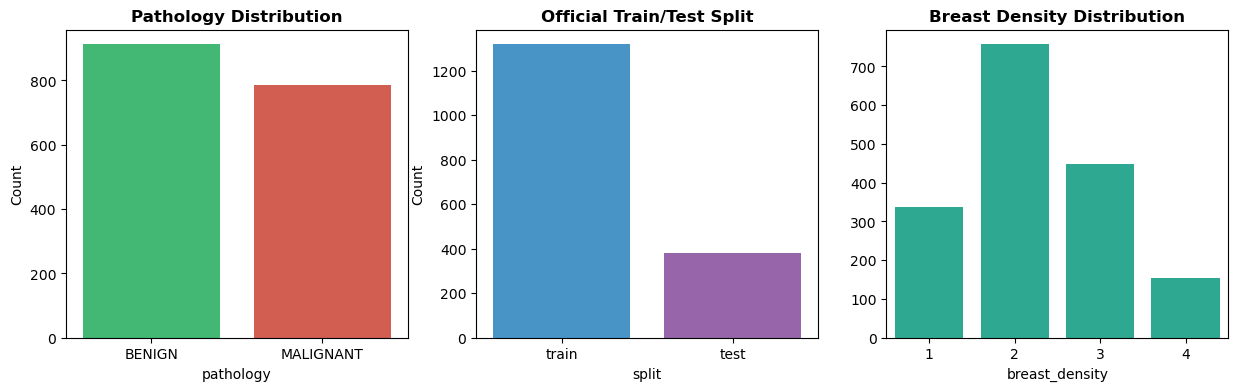

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Pathology distribution subplot
pathology_counts = df_mass['pathology'].value_counts()
sns.barplot(x=pathology_counts.index, y=pathology_counts.values, ax=axes[0], 
            palette=['#2ecc71', '#e74c3c'])
axes[0].set_title('Pathology Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')

# Train/Test split subplot
split_counts = df_mass['split'].value_counts()
sns.barplot(x=split_counts.index, y=split_counts.values, ax=axes[1], 
            palette=['#3498db', '#9b59b6'])
axes[1].set_title('Official Train/Test Split', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count')

# Breast density distribution subplot
if 'breast_density' in df_mass.columns:
    density_counts = df_mass['breast_density'].value_counts().sort_index()
    sns.barplot(x=density_counts.index.astype(str), y=density_counts.values, ax=axes[2], 
                color='#1abc9c')
    axes[2].set_title('Breast Density Distribution', fontsize=12, fontweight='bold')
    axes

## 2. Choose a Measure of Success
The __'calculate_clinical_metrics'__ defines what success is to be.

In [6]:
# Calculate clinical metrics
def calculate_clinical_metrics(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        # Handle edge case with single class
        auc = 0.5
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return {
        "Accuracy": acc,
        "AUC": auc,
        "Sensitivity": sensitivity,
        "Specificity": specificity
    }

In [7]:
# Evaluate model performance on test data
def evaluate_model(model, test_generator, y_true):
    test_generator.reset()
    
    y_prob = model.predict(test_generator).flatten()
    # Convert probabilities to binary
    y_pred = (y_prob > 0.5).astype(int)
    
    return calculate_clinical_metrics(y_true, y_pred, y_prob)

## 3. Decide on an Evaluation Protocol
### Train/Val Split and Preparation
Split the Training set into a Train and Validation set as 'Test' has been allocated originally.

This establishes the __Hold-Out Validation__ protocol.

In [8]:
# Separate the original test set
test_df = df_mass[df_mass['split'] == 'test'].copy()

# Split training data into train and validation sets (stratified)
full_train_df = df_mass[df_mass['split'] == 'train'].copy()
train_df, val_df = train_test_split(
    full_train_df,
    # 10% of the original training set
    test_size=CONFIG['val_ratio'],
    stratify=full_train_df['label'],
    random_state=CONFIG['random_seed']
)

# Update the 'split' labels
train_df['split'] = 'train'
val_df['split'] = 'val'

# Combine back into final dataset
df_final = pd.concat([train_df, val_df, test_df])

print("Data Split Ratios:")
print(df_final['split'].value_counts())
print("-" * 30)
print("Class Balance in New Training Set:")
print(train_df['label'].value_counts(normalize=True))

Data Split Ratios:
split
train    1186
test      378
val       132
Name: count, dtype: int64
------------------------------
Class Balance in New Training Set:
label
0    0.516863
1    0.483137
Name: proportion, dtype: float64


## 4. Prepare The Data
Format the tensors and normalise values.
### Helper Functions - DICOM Loading
- Read DICOM files
- Normalise pixel values 
- Accurately locate the ROI bounding box from the mask file

In [9]:
# Load DICOM file and return pixel array
def load_dicom_image(dicom_path):
    try:
        dcm = pydicom.dcmread(str(dicom_path))
        image = dcm.pixel_array
        return image
    except Exception as e:
        return None

# Normalise to 8-bit range [0, 255]
def normalize_dicom_to_8bit(image):
    if image is None: return None
    image_normalized = cv2.normalize(
        image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U
    )
    return image_normalized

# Handle missing paths
def fix_image_path(csv_path, base_dir):
    if pd.isna(csv_path):
        return None

    csv_path = str(csv_path).strip()
    # Extract the patient directory
    patient_dir_name = Path(csv_path).parts[0]
    patient_dir = base_dir / patient_dir_name

    if not patient_dir.exists():
        return None
    
    # Find the first .dcm file in patient directory (handles mismatched subfolders)
    dcm_files = list(patient_dir.rglob('*.dcm'))
    
    if not dcm_files:
        return None

    return dcm_files[0]

# Find the bounding box (x, y, width, height) from binary mask
def find_roi_bounding_box(roi_mask):
    if roi_mask is None: return None
    coords = np.argwhere(roi_mask > 0)
    if len(coords) == 0: return None
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    width = x_max - x_min + 1
    height = y_max - y_min + 1
    return (x_min, y_min, width, height)

### Helper Functions - ROI Extraction
Locate the center of the mass using the mask, determines a crop area (ensuring it's large enough to contain the mass plus padding, and at least crop_size), and returns the final 598×598 image.

In [10]:
# Crop ROI from full mammogram with padding
def crop_roi_with_context(full_image, roi_mask, target_size=598, padding=50):
    # Find bounding box
    bbox = find_roi_bounding_box(roi_mask)
    
    if bbox is None: return None, None
    
    x, y, w, h = bbox
    
    # Calculate ROI center
    center_x = x + w // 2
    center_y = y + h // 2
    
    # Determine crop size (larger of dimension + padding)
    max_dimension = max(w, h) + 2 * padding
    crop_size = max(max_dimension, target_size)
    
    # Calculate crop coordinates centered on ROI
    half_crop = crop_size // 2
    
    x1 = max(0, center_x - half_crop)
    y1 = max(0, center_y - half_crop)
    x2 = min(full_image.shape[1], center_x + half_crop)
    y2 = min(full_image.shape[0], center_y + half_crop)
    
    # Crop image
    cropped = full_image[y1:y2, x1:x2]
    
    # Resize to target size
    if cropped.shape[0] != target_size or cropped.shape[1] != target_size:
        cropped = cv2.resize(
            cropped,
            (target_size, target_size),
            interpolation=cv2.INTER_LANCZOS4
        )
    
    # Store metadata for debugging
    metadata = {
        'bbox': bbox, 'center': (center_x, center_y), 'final_size': (target_size, target_size)
    }
    
    return cropped, metadata

### Helper Functions - Plotting

In [11]:
# Plot training vs validation metrics
def plot_training_metrics(history, model_name="Model"):
    # Extract data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-o', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Analysis')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-o', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.title(f'{model_name} - Loss Analysis')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Binary Crossentropy)')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

### Execute Processing and Save Images
Iterate over the entire combined dataset, loads the DICOM files, crops the ROI, resizes to the final 224×224 model input size, and saves the image into the class-based directory structure (processed/split/label/image.png).

In [12]:
# Extract ROIs, resize, and save to train/val/test folders
def process_and_save_dataset(dataframe, base_dir, output_dir):
    stats = {'success': 0, 'missing_file': 0, 'failed_crop': 0}
    
    for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        
        # Determine output location
        class_name = 'malignant' if row['label'] == 1 else 'benign'
        split = row['split']
        save_dir = output_dir / split / class_name
        save_dir.mkdir(parents=True, exist_ok=True)
        
        clean_id = str(row['patient_id']).replace(" ", "")
        
        # Include row index to handle multiple masses per patient
        filename = f"{clean_id}_{row['left or right breast']}_{row['image view']}_{idx}.png"
        save_path = save_dir / filename
        
        # Skip if already processed
        if save_path.exists():
            stats['success'] += 1
            continue
            
        # Get paths to full mammogram and ROI mask
        full_dcm_path = fix_image_path(row['image file path'], base_dir)
        mask_dcm_path = fix_image_path(row['ROI mask file path'], base_dir)
        
        if not full_dcm_path.exists() or not mask_dcm_path.exists():
            stats['missing_file'] += 1
            continue
            
        # Extract ROI with context padding, resize, and save
        try:
            full_img = load_dicom_image(full_dcm_path)
            mask_img = load_dicom_image(mask_dcm_path)
            
            full_img = normalize_dicom_to_8bit(full_img)
            mask_img = normalize_dicom_to_8bit(mask_img)
            cropped, _ = crop_roi_with_context(
                full_img,
                mask_img,
                target_size=CONFIG['crop_size'],
                padding=CONFIG['padding_pixels']
            )
            
            if cropped is None:
                stats['failed_crop'] += 1
                continue
                
            # Resize to model input dimensions and save
            im_pil = Image.fromarray(cropped)
            im_pil = im_pil.resize((CONFIG['final_size'], CONFIG['final_size']), Image.LANCZOS)
            im_pil.save(save_path)
            stats['success'] += 1
            
        except Exception as e:
            stats['failed_crop'] += 1

    print(f"\nSuccessfully processed: {stats['success']} images")
    print(f"Missing files: {stats['missing_file']}")
    print(f"Failed to crop: {stats['failed_crop']}")

# Process and save all images
process_and_save_dataset(df_final, BASE_DIR, PROCESSED_DIR)

100%|███████████████████████████████████████| 1696/1696 [02:40<00:00, 10.53it/s]


Successfully processed: 1696 images
Missing files: 0
Failed to crop: 0


### Output Verification
Check that the images were saved correctly and display a few random examples.

Total images generated: 1696


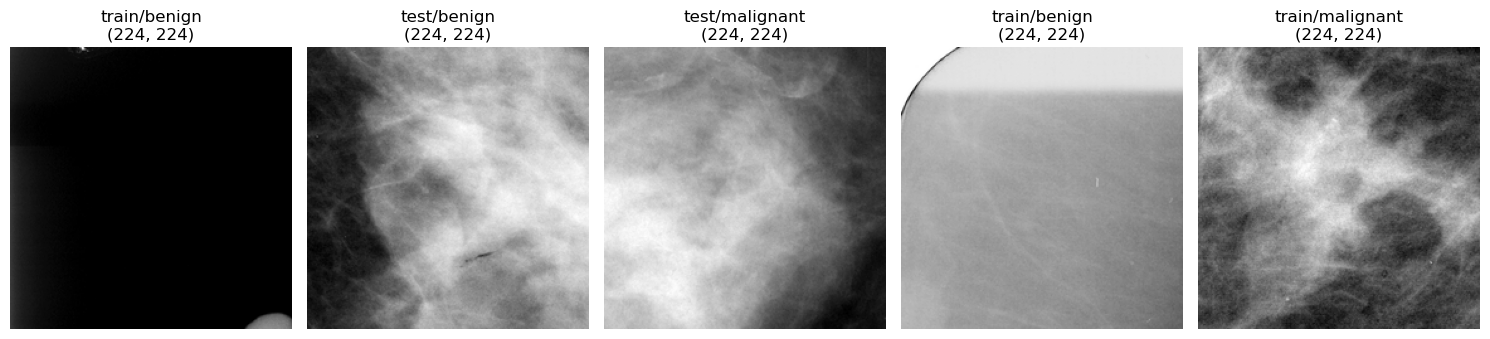

In [13]:
# Display random images
def verify_output(processed_dir):
    image_paths = list(Path(processed_dir).rglob("*.png"))
    
    if not image_paths:
        print("No images found!")
        return

    print(f"Total images generated: {len(image_paths)}")
    
    samples = random.sample(image_paths, min(5, len(image_paths)))
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))
    
    for i, img_path in enumerate(samples):
        img = Image.open(img_path)
        
        # Extract label and split from folder structure
        label = img_path.parent.name
        split = img_path.parent.parent.name
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"{split}/{label}\n{img.size}")
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

# Verify the processed images
verify_output(PROCESSED_DIR)

### Setup Data Generators (Baseline)
- Read data in small batches
- Process them (resize, normalise)
- Input them into the Neural Network
- Delete them from RAM and go to the next batch

In [14]:
# Define Parameters
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
SEED = 42

# Training generator with rescaling (no augmentation for baseline)
train_datagen = ImageDataGenerator(
    rescale=1./255
)

# Validation and Test generator (rescaling only)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Training Generator
print("Training Set:   ", end="")
train_generator = train_datagen.flow_from_directory(
    directory=PROCESSED_DIR / 'train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=SEED,
    shuffle=True
)

# Validation Generator
print("Validation Set: ", end="")
val_generator = test_datagen.flow_from_directory(
    directory=PROCESSED_DIR / 'val',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=SEED,
    shuffle=False
)

# Test Generator
print("Test Set:       ", end="")
test_generator = test_datagen.flow_from_directory(
    directory=PROCESSED_DIR / 'test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=SEED,
    shuffle=False
)

print("\nClass Mapping:", train_generator.class_indices)

Training Set:   Found 1186 images belonging to 2 classes.
Validation Set: Found 132 images belonging to 2 classes.
Test Set:       Found 378 images belonging to 2 classes.

Class Mapping: {'benign': 0, 'malignant': 1}


### The baseline to beat.

In [15]:
# Retrieve the true labels from the test set
test_generator.reset()
y_true = test_generator.classes

# Generate dummy predictions (always predict benign)
y_pred_dummy = np.zeros_like(y_true)
y_prob_dummy = np.zeros_like(y_true)

# Calculate baseline metrics
metrics_baseline = calculate_clinical_metrics(y_true, y_pred_dummy, y_prob_dummy)

print("Baseline Model")
print('-' * 30)
print(f"Accuracy:    {metrics_baseline['Accuracy']:.4f}")
print(f"AUC:         {metrics_baseline['AUC']:.4f}")
print(f"Sensitivity: {metrics_baseline['Sensitivity']:.4f}")
print(f"Specificity: {metrics_baseline['Specificity']:.4f}")

Baseline Model
------------------------------
Accuracy:    0.6111
AUC:         0.5000
Sensitivity: 0.0000
Specificity: 1.0000


# Part 2: Custom Model
## 5. Developing a Model that Does Better than a Baseline

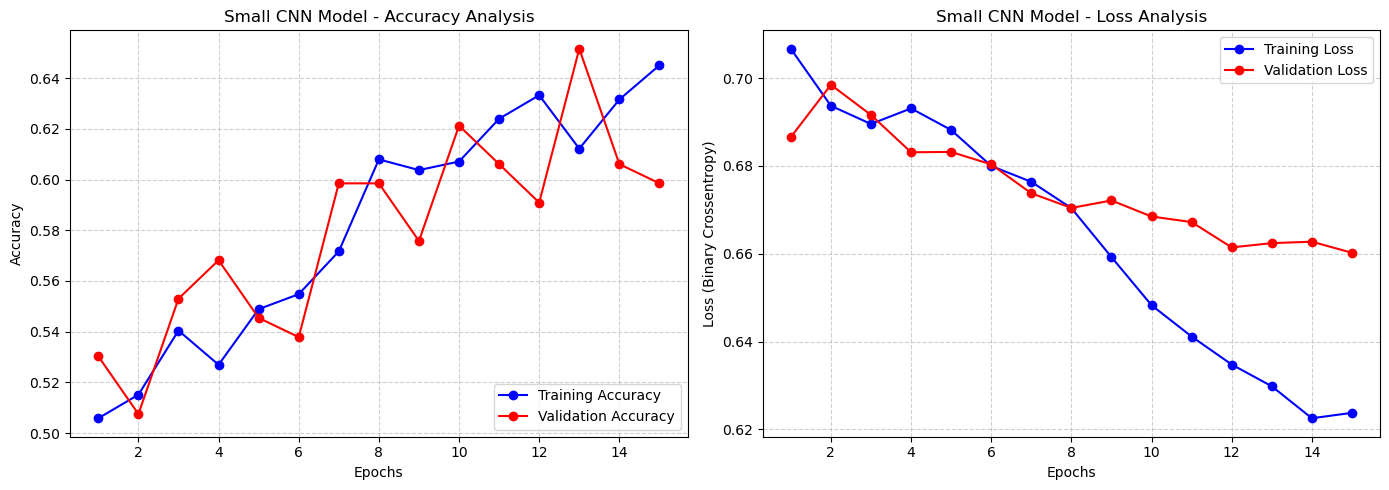

12/12 [==============================] - 1s 100ms/step
Small CNN Model
------------------------------
Accuracy:    0.5899
AUC:         0.6359
Sensitivity: 0.6531
Specificity: 0.5498


In [16]:
# Build small CNN to beat baseline 
def build_small_cnn():
    model = keras.Sequential([
        keras.Input(shape=(224, 224, 3)),
        
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Flatten(),
        layers.Dense(64, activation='relu'), 
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1e-4),
                  metrics=['accuracy'])
    return model

# Calculate weights for imbalanced data
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

train_class_weights = dict(enumerate(class_weights_vals))

# Train model
model_small_cnn = build_small_cnn()
history_small_cnn = model_small_cnn.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    class_weight=train_class_weights,
    verbose=0
)

plot_training_metrics(history_small_cnn, model_name="Small CNN Model")

# Test set evaluation
metrics_small_cnn = evaluate_model(model_small_cnn, test_generator, y_true)

print("Small CNN Model")
print('-' * 30)
print(f"Accuracy:    {metrics_small_cnn['Accuracy']:.4f}")
print(f"AUC:         {metrics_small_cnn['AUC']:.4f}")
print(f"Sensitivity: {metrics_small_cnn['Sensitivity']:.4f}")
print(f"Specificity: {metrics_small_cnn['Specificity']:.4f}")

## Scale Up (Overfitting)

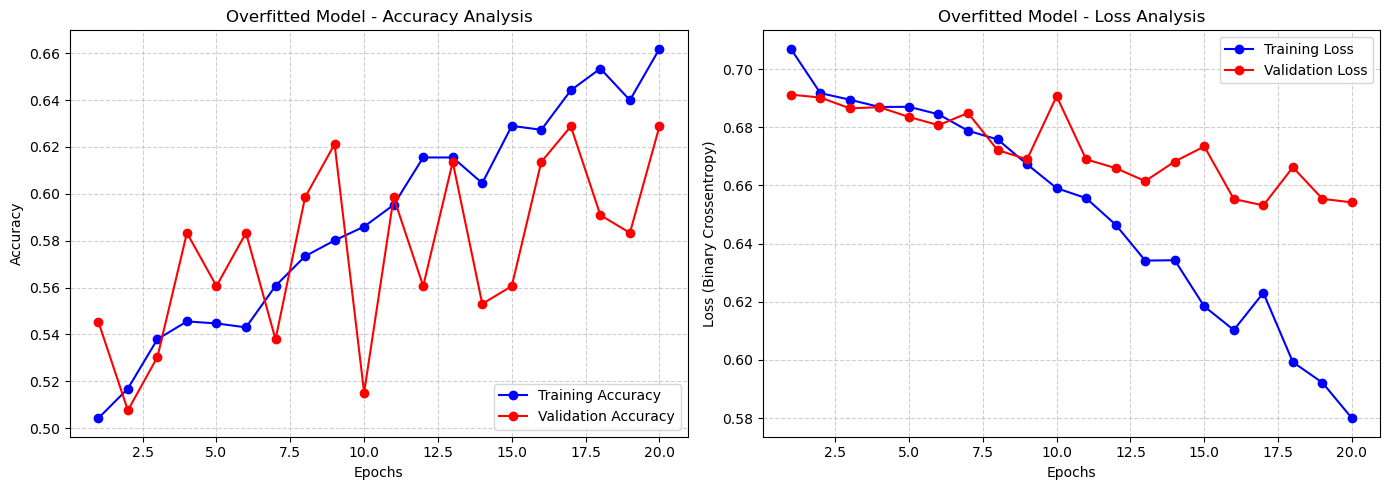

12/12 [==============================] - 4s 322ms/step
Overfitted Model
------------------------------
Accuracy:    0.6164
AUC:         0.6454
Sensitivity: 0.5986
Specificity: 0.6277


In [17]:
# Build a model to overfit
def build_overfitted_model():
    model = keras.Sequential([
        keras.Input(shape=(224, 224, 3)),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1e-4),
                  metrics=['accuracy'])
    return model

# Train model
model_overfitted = build_overfitted_model()
history_overfitted = model_overfitted.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=train_class_weights,
    verbose=0
)

plot_training_metrics(history_overfitted, model_name="Overfitted Model")

# Test set evaluation
metrics_overfitted = evaluate_model(model_overfitted, test_generator, y_true)

print("Overfitted Model")
print('-' * 30)
print(f"Accuracy:    {metrics_overfitted['Accuracy']:.4f}")
print(f"AUC:         {metrics_overfitted['AUC']:.4f}")
print(f"Sensitivity: {metrics_overfitted['Sensitivity']:.4f}")
print(f"Specificity: {metrics_overfitted['Specificity']:.4f}")

## Regularise

Found 1186 images belonging to 2 classes.


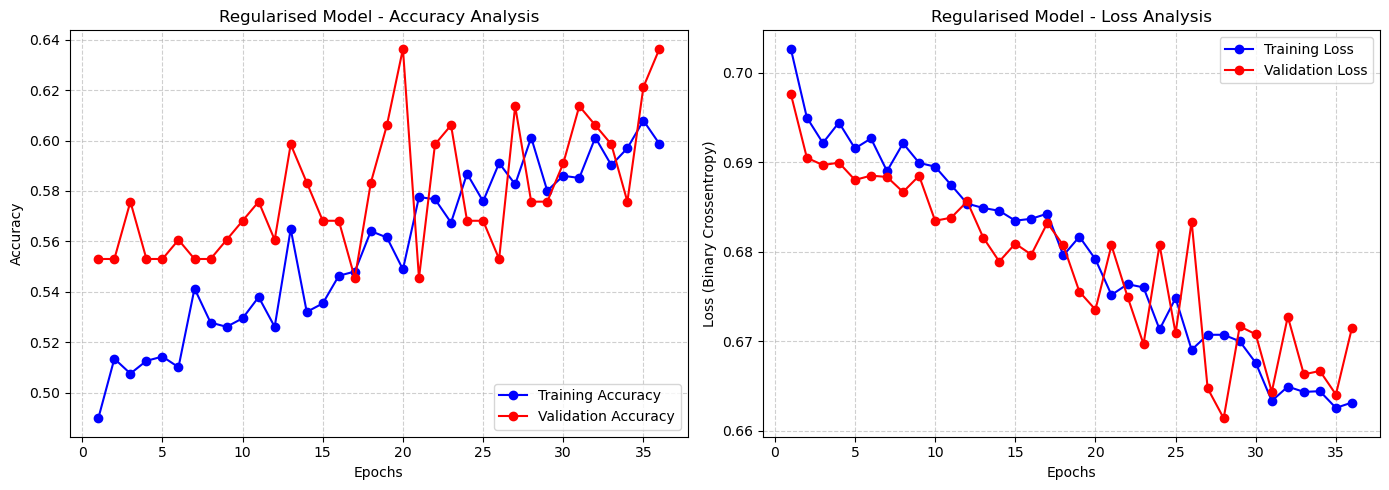

12/12 [==============================] - 4s 347ms/step
Regularised Model
------------------------------
Accuracy:    0.5873
AUC:         0.6438
Sensitivity: 0.6395
Specificity: 0.5541


In [18]:
# Define augmented data generator 
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_aug = train_datagen_aug.flow_from_directory(
    directory=PROCESSED_DIR / 'train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    seed=42,
    shuffle=True
)

# Build regularised model
def build_regularised_model():
    model = keras.Sequential([
        keras.Input(shape=(224, 224, 3)),
        
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Flatten(),
        layers.Dropout(0.5), 
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1e-4),
                  metrics=['accuracy'])
    return model

# Train model
model_regularised = build_regularised_model()

# Early Stopping
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=8, 
        restore_best_weights=True
    )
]

history_regularised = model_regularised.fit(
    train_generator_aug,
    epochs=40,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=train_class_weights,
    verbose=0
)

plot_training_metrics(history_regularised, model_name="Regularised Model")

# Test set evaluation
metrics_regularised = evaluate_model(model_regularised, test_generator, y_true)

print("Regularised Model")
print('-' * 30)
print(f"Accuracy:    {metrics_regularised['Accuracy']:.4f}")
print(f"AUC:         {metrics_regularised['AUC']:.4f}")
print(f"Sensitivity: {metrics_regularised['Sensitivity']:.4f}")
print(f"Specificity: {metrics_regularised['Specificity']:.4f}")

In [19]:
# Aggregate results
results_data = {
    'Baseline Model': metrics_baseline,
    'Small CNN Model': metrics_small_cnn,
    'Overfitted CNN Model': metrics_overfitted,
    'Regularised CNN Model': metrics_regularised
}

df_results = pd.DataFrame(results_data).T

print("\nComparative Summary")
display(df_results.round(4))


Comparative Summary


,Accuracy,AUC,Sensitivity,Specificity
Baseline Model,0.6111,0.5000,0.0000,1.0000
Small CNN Model,0.5899,0.6359,0.6531,0.5498
Overfitted CNN Model,0.6164,0.6454,0.5986,0.6277
Regularised CNN Model,0.5873,0.6438,0.6395,0.5541


In [20]:
# Save results
model_small_cnn.save('small_cnn_prototype.h5')

__Note:__
From this point onward, all preprocessing, training, and evaluation results are produced using the corrected ROI extraction pipeline and the Chollet-compliant experimental workflow. Code cells above this section are retained for traceability but are not used in the final analysis.

# Protocol Recalibration and Data Integrity Verification
During the initial exploratory phase, preliminary models were trained and evaluated to establish a working pipeline. Subsequent analysis revealed issues in both ROI preprocessing and dataset partition usage. To ensure compliance with the Universal Workflow for machine learning (Chollet, 2018) and to guarantee data integrity, the preprocessing and experimental protocol were recalibrated. From this section onward, all reported results are generated using the corrected ROI extraction pipeline and a validation-driven model selection framework, with the test set reserved exclusively for final evaluation.
## 1. Define the Problem and Assemble a Dataset
The task is binary classification of breast masses as benign or malignant using lesion-centred mammographic ROIs from CBIS-DDSM.
### Import Libraries

In [1]:
# Core libraries
import numpy as np
import pandas as pd
from pathlib import Path

# Image processing
import pydicom
import cv2
from PIL import Image

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, confusion_matrix,
    classification_report, precision_score, recall_score,
    roc_curve, precision_recall_curve, auc, brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.utils import class_weight
from sklearn.model_selection import GroupShuffleSplit

# Deep Learning 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.metrics import F1Score

# Utilities
import os
import json
from tqdm import tqdm
import random
import time
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

### Seeds & Callbacks
To ensure reproducibility.

In [2]:
# Global seed for reproducibility
SEED = 42

# Training parameters
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Training Epochs
MAX_EPOCHS = 100
PATIENCE = 15

# Define callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        min_delta=0.0001,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_delta=0.0001,
        min_lr=1e-7,
        verbose=1
    )
]

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Seeds set to: {seed}")

# Initialise reproducibility
set_seed(SEED)

Seeds set to: 42


### Paths

In [3]:
# Base paths 
BASE_DIR = Path("/Users/ay/Desktop/FYP/data/CBIS-DDSM")  
METADATA_DIR = BASE_DIR
DICOM_DIR = BASE_DIR 

# Output directories
OUTPUT_BASE = Path("/Users/ay/Downloads/Github/FYP/processed_data")
CROPPED_IMAGES_DIR = OUTPUT_BASE / "cropped_rois"
PROCESSED_GREYSCALE_DIR = OUTPUT_BASE / "processed_greyscale"
PROCESSED_GREYSCALE_CLAHE_DIR = OUTPUT_BASE / "processed_greyscale_clahe"
FIGURES_DIR = OUTPUT_BASE / "figures"
MODEL_DIR = OUTPUT_BASE / "models"

# Create output directories
for dir_path in [CROPPED_IMAGES_DIR, PROCESSED_GREYSCALE_DIR, PROCESSED_GREYSCALE_CLAHE_DIR, FIGURES_DIR, MODEL_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Output directory: {OUTPUT_BASE}")
print(f"Greyscale output: {PROCESSED_GREYSCALE_DIR}")
print(f"Greyscale+CLAHE output: {PROCESSED_GREYSCALE_CLAHE_DIR}")
print(f"Model directory: {MODEL_DIR}")

Base directory: /Users/ay/Desktop/FYP/data/CBIS-DDSM
Output directory: /Users/ay/Downloads/Github/FYP/processed_data
Greyscale output: /Users/ay/Downloads/Github/FYP/processed_data/processed_greyscale
Greyscale+CLAHE output: /Users/ay/Downloads/Github/FYP/processed_data/processed_greyscale_clahe
Model directory: /Users/ay/Downloads/Github/FYP/processed_data/models


### Configuration
The validation ratio is a fraction of CBIS TRAIN only.

In [4]:
# Processing parameters
CONFIG = {
    'crop_size': 598,
    'padding_pixels': 50,
    'final_size': 224,
    'val_ratio': 0.10,
    'random_seed': SEED
}

# Save configuration
with open(OUTPUT_BASE / 'config.json', 'w') as f:
    json.dump({k: str(v) if isinstance(v, Path) else v 
               for k, v in CONFIG.items()}, f, indent=2)

### Load and Explore the Metadata

In [5]:
# Load metadata
train_meta_path = METADATA_DIR / "mass_case_description_train_set.csv"
test_meta_path  = METADATA_DIR / "mass_case_description_test_set.csv"

df_train = pd.read_csv(train_meta_path)
df_test  = pd.read_csv(test_meta_path)

print("\nPathology labels (train):")
print(df_train["pathology"].value_counts())

print("\nPathology labels (test):")
print(df_test["pathology"].value_counts())

# Add split indicator following CBIS DDSM official split
df_train["split"] = "train"
df_test["split"]  = "test"

# Combine and filter for MASS cases (case-insensitive)
df_all = pd.concat([df_train, df_test], ignore_index=True)
df_mass = df_all[df_all["abnormality type"].astype(str).str.lower() == "mass"].copy()

# Standardise pathology labels (strip + merge benign_without_callback)
df_mass["pathology"] = df_mass["pathology"].astype(str).str.strip().replace({
    "BENIGN_WITHOUT_CALLBACK": "BENIGN"
})

# Binary labels (0=BENIGN, 1=MALIGNANT)
df_mass["label"] = (df_mass["pathology"] == "MALIGNANT").astype(int)

print(f"\nTotal MASS cases after cleaning: {len(df_mass)}")
print("Binary Label Distribution:")
print(df_mass["label"].value_counts())
print(f"Malignant proportion: {(df_mass['label'] == 1).mean():.2%}")


Pathology labels (train):
pathology
MALIGNANT                  637
BENIGN                     577
BENIGN_WITHOUT_CALLBACK    104
Name: count, dtype: int64

Pathology labels (test):
pathology
BENIGN                     194
MALIGNANT                  147
BENIGN_WITHOUT_CALLBACK     37
Name: count, dtype: int64

Total MASS cases after cleaning: 1696
Binary Label Distribution:
label
0    912
1    784
Name: count, dtype: int64
Malignant proportion: 46.23%


### Visualisation of Class Distribution

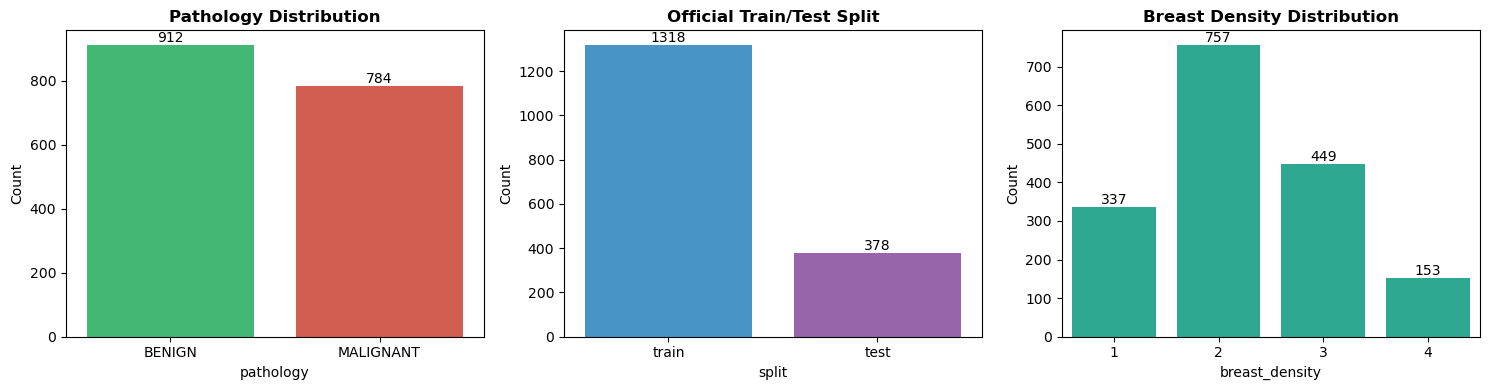

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Pathology distribution subplot
pathology_counts = df_mass['pathology'].value_counts()
bars1 = sns.barplot(x=pathology_counts.index, y=pathology_counts.values, ax=axes[0], 
                    palette=['#2ecc71', '#e74c3c'])
axes[0].set_title('Pathology Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count')
# Add values on bars
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d')

# Train/Test split subplot
split_counts = df_mass['split'].value_counts()
bars2 = sns.barplot(x=split_counts.index, y=split_counts.values, ax=axes[1], 
                    palette=['#3498db', '#9b59b6'])
axes[1].set_title('Official Train/Test Split', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count')
# Add values on bars
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%d')

# Breast density distribution subplot
if 'breast_density' in df_mass.columns:
    density_counts = df_mass['breast_density'].value_counts().sort_index()
    bars3 = sns.barplot(x=density_counts.index.astype(str), y=density_counts.values, ax=axes[2], 
                        color='#1abc9c')
    axes[2].set_title('Breast Density Distribution', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Count')
    # Add values on bars
    for container in axes[2].containers:
        axes[2].bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

## 2. Choosing a Measure of Success
Performance is measured using AUC as the primary metric, with accuracy, sensitivity, and specificity reported as secondary clinical metrics.

In [7]:
def calc_clinical_metrics(y_true, y_pred, y_prob):
    # Basic metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # AUC
    try:
        auc_score = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc_score = 0.5
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Clinical metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = precision
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Calibration
    brier = brier_score_loss(y_true, y_prob)
    
    return {
        "Accuracy": acc,
        "AUC-ROC": auc_score,
        "F1-Score": f1,
        "Precision (PPV)": ppv,
        "Recall (Sensitivity)": sensitivity,
        "Specificity": specificity,
        "NPV": npv,
        "Brier Score": brier,
        "Confusion Matrix": {
            "TP": int(tp), "TN": int(tn),
            "FP": int(fp), "FN": int(fn)
        }
    }

## 3. Decide on an Evaluation Protocol
All models are trained on the CBIS-DDSM training set, tuned on a patient-level validation split, and evaluated once on the held-out CBIS-DDSM test set.  

This project will evaluate with both an internal and external dataset.

In [8]:
# Separate the official CBIS test set
test_df = df_mass[df_mass['split'] == 'test'].copy()

# CBIS official training set
full_train_df = df_mass[df_mass['split'] == 'train'].copy()

# Create/ensure patient_core exists
if 'patient_core' not in full_train_df.columns:
    full_train_df['patient_core'] = full_train_df['patient_id'].astype(str).str.extract(r'^(.*?_P_\d+)')[0].fillna(full_train_df['patient_id'].astype(str))

# Group shuffle split to prevent patient leakage
gss = GroupShuffleSplit(
    n_splits=1,
    test_size=CONFIG['val_ratio'],
    random_state=CONFIG['random_seed']
)

train_idx, val_idx = next(gss.split(
    full_train_df,
    full_train_df['label'],
    groups=full_train_df['patient_core']
))

train_df = full_train_df.iloc[train_idx].copy()
val_df   = full_train_df.iloc[val_idx].copy()

train_df['split'] = 'train'
val_df['split']   = 'val'
test_df['split']  = 'test'

df_final = pd.concat([train_df, val_df, test_df], ignore_index=True)

print("Data split counts:")
print(df_final['split'].value_counts())
print("-" * 30)
print("Class balance (train):")
print(train_df['label'].value_counts(normalize=True))
print("Class balance (val):")
print(val_df['label'].value_counts(normalize=True))
print("Class balance (test):")
print(test_df['label'].value_counts(normalize=True))

Data split counts:
split
train    1181
test      378
val       137
Name: count, dtype: int64
------------------------------
Class balance (train):
label
0    0.521592
1    0.478408
Name: proportion, dtype: float64
Class balance (val):
label
1    0.525547
0    0.474453
Name: proportion, dtype: float64
Class balance (test):
label
0    0.611111
1    0.388889
Name: proportion, dtype: float64


Ensures patient-level separation (no data leakage between train/test)
Allows comparison with published benchmarks
Maintains reproducibility with existing literature  

This methodology guarantees strict patient-level separation to prevent data leakage between the training and testing sets. Furthermore, it facilitates direct comparisons with published benchmarks while ensuring that the results remain reproducible and consistent with existing clinical literature.

#### Check for Data Leakage

In [9]:
train_pat = set(train_df['patient_core'])
val_pat   = set(val_df['patient_core'])
test_pat  = set(test_df.get('patient_core', test_df.get('patient_id')))

print("Patient overlap between train and val :", len(train_pat & val_pat))
print("Patient overlap between train and test:", len(train_pat & test_pat))
print("Patient overlap between val and test  :", len(val_pat & test_pat))

Patient overlap between train and val : 0
Patient overlap between train and test: 0
Patient overlap between val and test  : 0


This confirms that no patient identifiers overlap across the training, validation, and testing subsets. Preventing data leakage and ensuring that the model is evaluated on its ability to generalise to entirely unseen biological profiles, rather than memorising patient-specific characteristics. This approach maintains the statistical independence required for valid clinical performance metrics. 

## 4. Prepare the Data
### Helper Functions - DICOM Loading Functions
- Read DICOM files
- Normalise pixel values
- Accurately locate the ROI bounding box from the mask file

In [10]:
# Load DICOM file and return pixel array
def load_dicom_image(dicom_path):
    dcm = pydicom.dcmread(str(dicom_path))
    return dcm.pixel_array

# Normalise to 8-bit range [0, 255]
def normalize_dicom_to_8bit(image):
    if image is None: return None
    image_normalized = cv2.normalize(
        image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U
    )
    return image_normalized

### Path Fixing Function

In [11]:
# Handle missing paths and find DICOM files
def fix_image_path(csv_path, base_dir, want_mask=False):
    if pd.isna(csv_path) or csv_path is None:
        return None
    
    csv_path = str(csv_path).strip().replace("\\", "/")
    patient_folder = csv_path.split("/")[0]
    patient_dir = base_dir / patient_folder
    
    if not patient_dir.exists():
        return None
    
    if want_mask:
        # ROI mask
        candidates = list(patient_dir.rglob("*ROI*mask*images*"))
    else:
        # Full mammogram, fallback to cropped images
        candidates = list(patient_dir.rglob("*full*mammogram*images*"))
        if not candidates:
            candidates = list(patient_dir.rglob("*cropped*images*"))
    
    if not candidates:
        return None
    
    series_dir = candidates[0]
    dcm_files = list(series_dir.rglob("*.dcm"))
    
    return dcm_files[0] if dcm_files else None

### ROI Bounding Box Function

In [12]:
# Find the bounding box (x, y, width, height) from binary mask
def find_roi_bounding_box(roi_mask):
    if roi_mask is None: 
        return None
    
    coords = np.argwhere(roi_mask > 0)
    if len(coords) == 0: 
        return None
    
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    width = x_max - x_min + 1
    height = y_max - y_min + 1
    
    return (x_min, y_min, width, height)

### Helper Function - ROI Cropping Function
Locate the center of the mass using the mask, determines a crop area (ensuring it's large enough to contain the mass plus padding, and at least crop_size), and returns the final 598×598 image.

In [13]:
# Crop ROI with surrounding context
def crop_roi_with_context(full_image, roi_mask, target_size=598, padding=50):
    # Ensure roi_mask is binary
    bbox = find_roi_bounding_box(roi_mask)
    if bbox is None:
        return None, {"reason": "no_mask_pixels"}
    
    x, y, w, h = bbox
    center_x = x + w // 2
    center_y = y + h // 2
    
    max_dimension = max(w, h) + 2 * padding
    crop_size = max(max_dimension, target_size)
    half_crop = crop_size // 2
    
    x1 = max(0, center_x - half_crop)
    y1 = max(0, center_y - half_crop)
    x2 = min(full_image.shape[1], center_x + half_crop)
    y2 = min(full_image.shape[0], center_y + half_crop)
    
    cropped = full_image[y1:y2, x1:x2]
    
    # Verify if lesion is inside the crop
    mask_crop = roi_mask[y1:y2, x1:x2]
    if mask_crop.sum() == 0:
        return None, {"reason": "mask_not_in_crop", "bbox": bbox}
    
    if cropped.shape[0] != target_size or cropped.shape[1] != target_size:
        cropped = cv2.resize(
            cropped,
            (target_size, target_size),
            interpolation=cv2.INTER_LANCZOS4
        )
    
    metadata = {
        "bbox": bbox,
        "center": (center_x, center_y),
        "final_size": (target_size, target_size)
    }
    
    return cropped, metadata

### Multi-Channel Preprocessing Functions
#### CLAHE Function
Contrast Limited Adaptive Histogram Equalization

In [14]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

### Execute Processing and Save Images
Iterate over the entire combined dataset, loads the DICOM files, crops the ROI, resizes to the final 224×224 model input size, and saves the image into the class-based directory structure (processed/split/label/image.png).

In [15]:
def process_and_save_dataset(dataframe, base_dir, output_dir_greyscale, output_dir_clahe):
    stats = {
        'success': 0,
        'missing_file': 0,
        'failed_crop': 0,
        'shape_mismatch': 0,
        'empty_mask': 0
    }
    
    print(f"\nProcessing {len(dataframe)} images.")
    print(f"Greyscale output: {output_dir_greyscale}")
    print(f"Greyscale+CLAHE output: {output_dir_clahe}")
    
    for idx, row in tqdm(list(dataframe.iterrows()), desc="Processing images"):
        
        class_name = 'malignant' if row['label'] == 1 else 'benign'
        split = row['split']
        
        # Define save directories for both preprocessing types
        save_dir_greyscale = output_dir_greyscale / split / class_name
        save_dir_clahe = output_dir_clahe / split / class_name
        save_dir_greyscale.mkdir(parents=True, exist_ok=True)
        save_dir_clahe.mkdir(parents=True, exist_ok=True)
        
        # Get image and mask paths
        image_path_col = 'image file path'
        mask_path_col = 'ROI mask file path'
        
        full_img_path = fix_image_path(row[image_path_col], base_dir, want_mask=False)
        mask_img_path = fix_image_path(row[mask_path_col], base_dir, want_mask=True)
        
        if full_img_path is None or mask_img_path is None:
            stats['missing_file'] += 1
            continue
        
        # Load DICOM files
        try:
            full_img = load_dicom_image(full_img_path)
            mask_img = load_dicom_image(mask_img_path)
        except Exception as e:
            stats['missing_file'] += 1
            continue
        
        # Normalise to 8-bit
        full_8 = normalize_dicom_to_8bit(full_img)
        mask_8 = normalize_dicom_to_8bit(mask_img)
        
        if full_8 is None or mask_8 is None:
            stats['missing_file'] += 1
            continue
        
        # Handle shape mismatch
        if full_8.shape != mask_8.shape:
            mask_8 = cv2.resize(
                mask_8,
                (full_8.shape[1], full_8.shape[0]),
                interpolation=cv2.INTER_NEAREST
            )
            stats['shape_mismatch'] += 1
    
        # Ensure mask is binary
        _, mask_binary = cv2.threshold(mask_8, 127, 255, cv2.THRESH_BINARY)
        
        # Crop ROI with context
        cropped_8, crop_meta = crop_roi_with_context(
            full_8, 
            mask_binary,
            target_size=CONFIG['crop_size'],
            padding=CONFIG['padding_pixels']
        )
        
        if cropped_8 is None:
            stats['failed_crop'] += 1
            continue
        
        # Resize to final model input size
        cropped_resized = cv2.resize(
            cropped_8,
            (CONFIG['final_size'], CONFIG['final_size']),
            interpolation=cv2.INTER_LANCZOS4
        )
        
        # Generate filename
        filename = f"{row.name}_{class_name}.png"
        save_path_greyscale = save_dir_greyscale / filename
        save_path_clahe = save_dir_clahe / filename
        
        # Preprocessing (Greyscale)
        im_greyscale = Image.fromarray(cropped_resized, mode='L')
        im_greyscale.save(save_path_greyscale)
        
        # Preprocessing (Greyscale + CLAHE)
        clahe_enhanced = apply_clahe(cropped_resized)
        
        # Save as RGB PNG (duplicate the 2 channels to create a 3-channel image for PNG compatibility)
        greyscale_clahe_rgb = np.stack([cropped_resized, clahe_enhanced, cropped_resized], axis=-1)
        im_clahe = Image.fromarray(greyscale_clahe_rgb, mode='RGB')
        im_clahe.save(save_path_clahe)
        
        stats['success'] += 1
    
    print(f"\nProcessing Summary:")
    print('-' * 50)
    for k, v in stats.items():
        print(f"{k}: {v}")
    
    return stats

stats = process_and_save_dataset(df_final, BASE_DIR, PROCESSED_GREYSCALE_DIR, PROCESSED_GREYSCALE_CLAHE_DIR)


Processing 1696 images.
Greyscale output: /Users/ay/Downloads/Github/FYP/processed_data/processed_greyscale
Greyscale+CLAHE output: /Users/ay/Downloads/Github/FYP/processed_data/processed_greyscale_clahe


Processing images: 100%|██████████████████| 1696/1696 [4:27:49<00:00,  9.48s/it]


Processing Summary:
--------------------------------------------------
success: 1694
missing_file: 2
failed_crop: 0
shape_mismatch: 663
empty_mask: 0


ROI crops were successfully generated for 1,694 cases. Two cases were excluded due to missing DICOM files. In 663 cases, ROI mask dimensions differed from the mammogram resolution; masks were resized to the mammogram dimensions using nearest-neighbour interpolation to preserve binary labels before lesion-centred cropping.

In [16]:
# Verify file counts for each preprocessing type
print("Preprocessed Greyscale Files:")
print("-"*50)
for split in ["train", "val", "test"]:
    n = len(list((PROCESSED_GREYSCALE_DIR / split).rglob("*.png")))
    print(f"{split}: {n} images")

print("\nPreprocessed Greyscale + CLAHE Files:")
print("-"*50)
for split in ["train", "val", "test"]:
    n = len(list((PROCESSED_GREYSCALE_CLAHE_DIR / split).rglob("*.png")))
    print(f"{split}: {n} images")

Preprocessed Greyscale Files:
--------------------------------------------------
train: 1181 images
val: 137 images
test: 376 images

Preprocessed Greyscale + CLAHE Files:
--------------------------------------------------
train: 1181 images
val: 137 images
test: 376 images


### Output Verification
Check that the images were saved correctly and display a few random examples.

Verify Greyscale Samples:
--------------------------------------------------


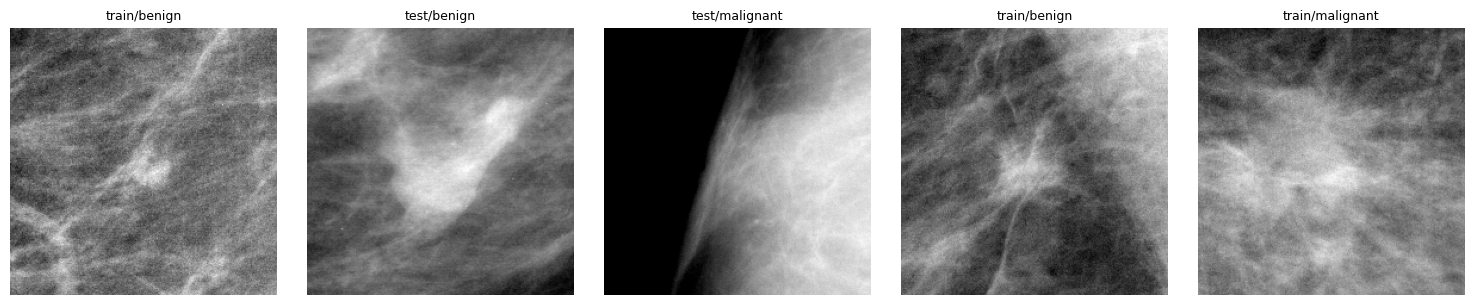

Verified 5 samples from 1694 total images

Verify Greyscale + CLAHE Samples:
--------------------------------------------------


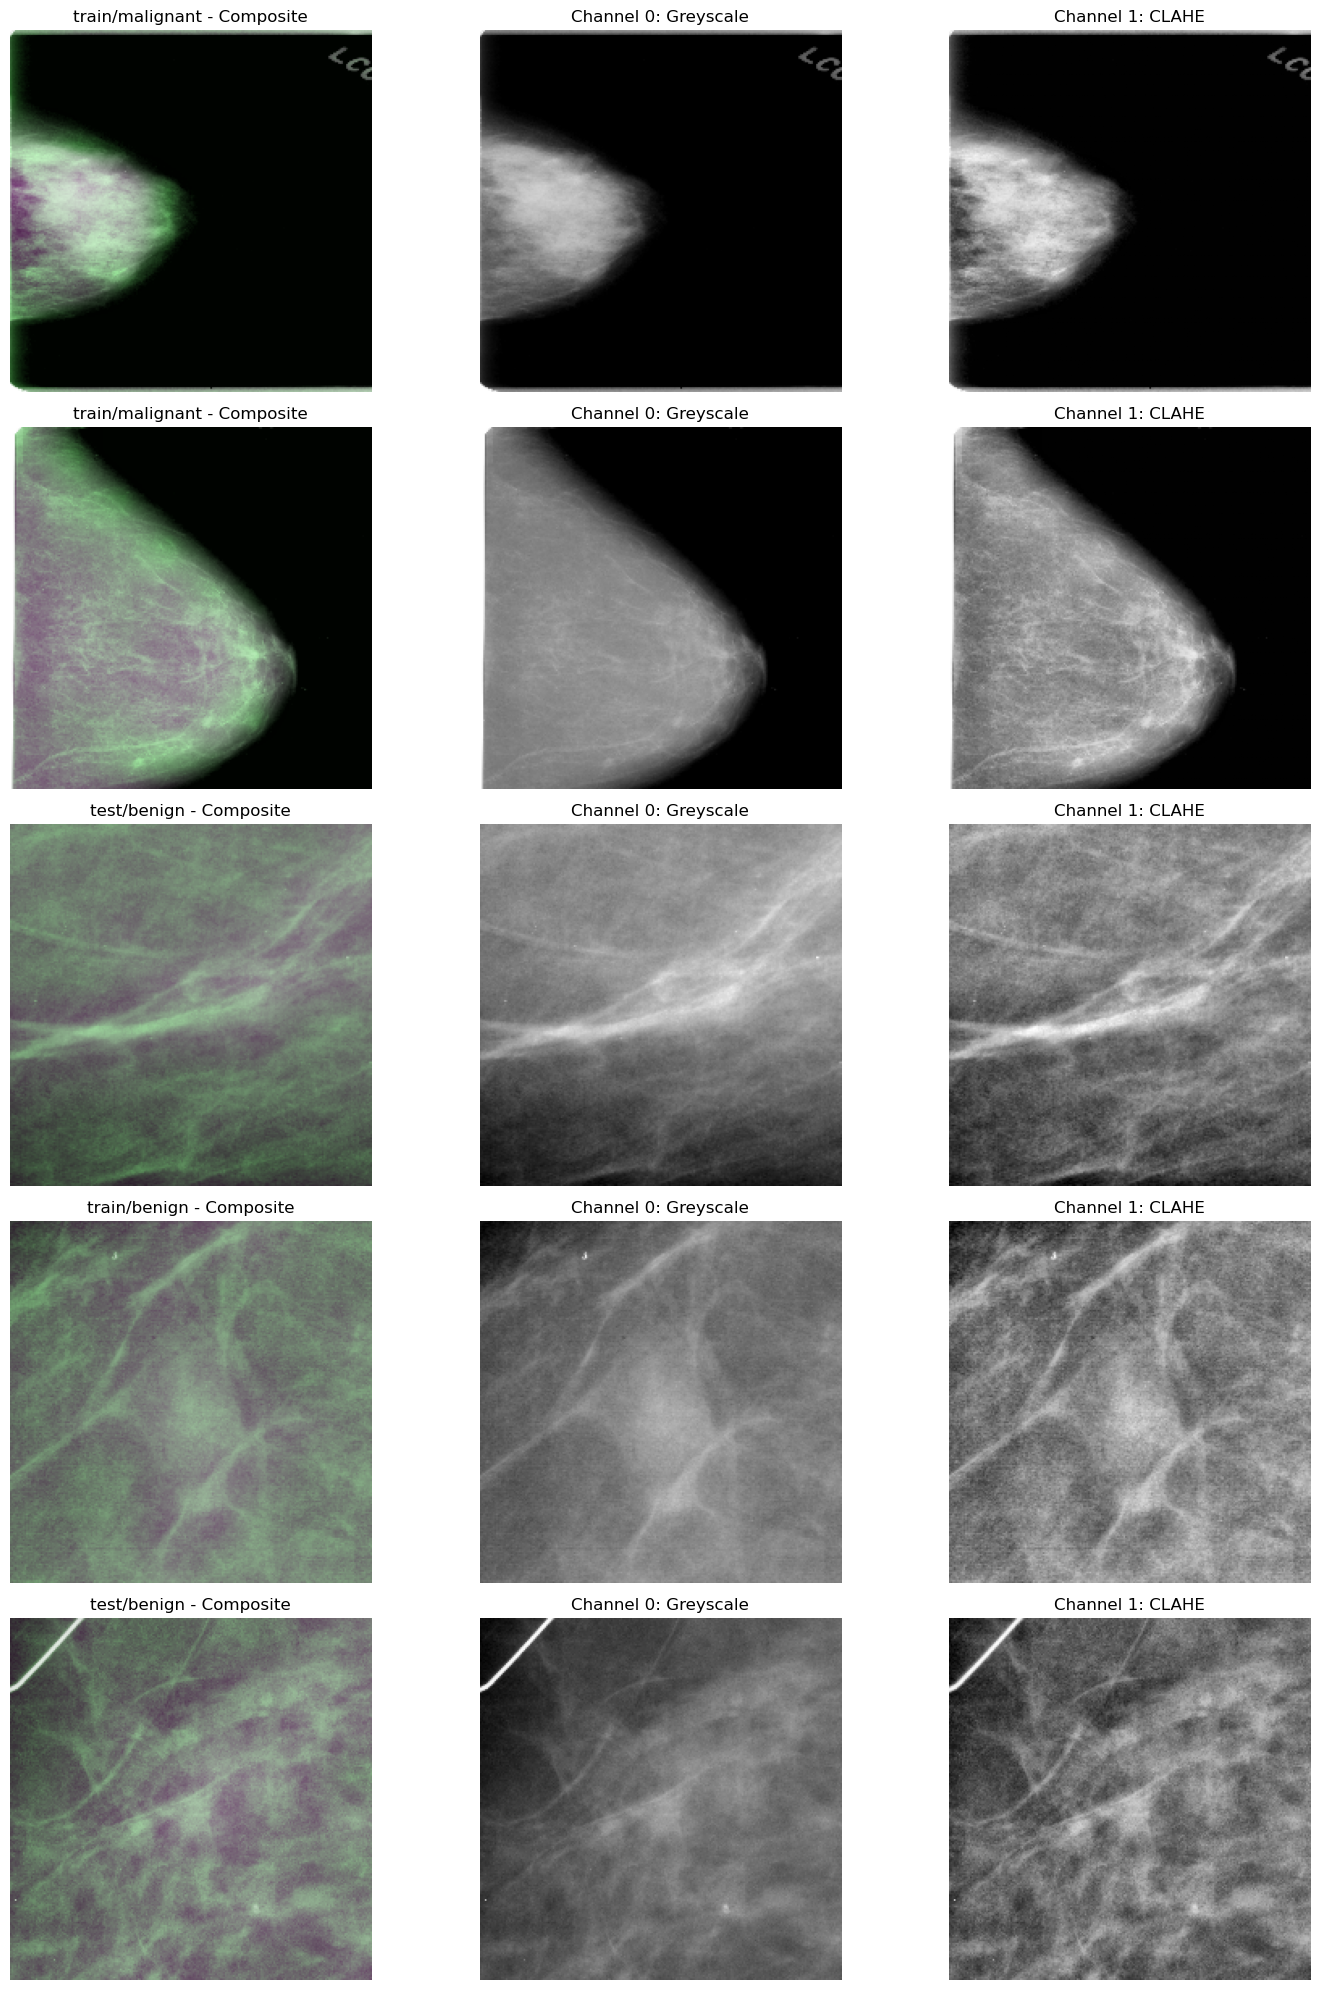

Verified 5 samples from 1694 total images


In [18]:
def verify_samples(processed_dir, preprocessing_type="greyscale", n=5):
    paths = list(Path(processed_dir).rglob("*.png"))
    samples = random.sample(paths, min(n, len(paths)))
    
    if preprocessing_type == "greyscale":
        # Grid layout for greyscale - more compact
        cols = min(5, n)
        rows = (n + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
        
        # Handle different axes shapes
        if n == 1:
            axes = np.array([axes])
        axes = axes.flatten() if n > 1 else axes
        
        for i, path in enumerate(samples):
            img = np.array(Image.open(path))
            label = path.parent.name
            split = path.parent.parent.name
            
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"{split}/{label}", fontsize=9)
            axes[i].axis('off')
        
        # Hide unused subplots
        for i in range(len(samples), len(axes)):
            axes[i].axis('off')
    
    elif preprocessing_type == "greyscale_clahe":
        # Two channel visualisation (extracted from RGB)
        fig, axes = plt.subplots(n, 3, figsize=(15, 4*n))
        if n == 1:
            axes = axes.reshape(1, -1)
        
        for i, path in enumerate(samples):
            img = np.array(Image.open(path))
            label = path.parent.name
            split = path.parent.parent.name
            
            # Extract the two meaningful channels (channels 0 and 1)
            greyscale_channel = img[:, :, 0]
            clahe_channel = img[:, :, 1]
            
            # Display composite
            axes[i, 0].imshow(img)
            axes[i, 0].set_title(f"{split}/{label} - Composite")
            axes[i, 0].axis('off')
            
            # Display greyscale channel
            axes[i, 1].imshow(greyscale_channel, cmap='gray')
            axes[i, 1].set_title("Channel 0: Greyscale")
            axes[i, 1].axis('off')
            
            # Display CLAHE channel
            axes[i, 2].imshow(clahe_channel, cmap='gray')
            axes[i, 2].set_title("Channel 1: CLAHE")
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"Verified {n} samples from {len(paths)} total images")
    
# Verify Greyscale Samples
print("Verify Greyscale Samples:")
print("-"*50)
verify_samples(PROCESSED_GREYSCALE_DIR, preprocessing_type="greyscale", n=5)
    
# Verify Greyscale + CLAHE Samples
print("\nVerify Greyscale + CLAHE Samples:")
print("-"*50)
verify_samples(PROCESSED_GREYSCALE_CLAHE_DIR, preprocessing_type="greyscale_clahe", n=5)

In [19]:
# Plot training vs validation metrics
def plot_training_metrics(history, model_name="Model"):
    # Extract data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-o', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Analysis')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-o', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.title(f'{model_name} - Loss Analysis')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Binary Crossentropy)')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

### Data Generators

In [20]:
# Training generator (no augmentation for baseline/small CNN phases)
train_datagen = ImageDataGenerator(
    rescale=1./255
)

# Validation and Test generator (rescaling only)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [21]:
# Use single channel greyscale (most basic approach)
IMG_CHANNELS = 1

train_gen = train_datagen.flow_from_directory(
    directory=PROCESSED_GREYSCALE_DIR / 'train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    seed=SEED,
    shuffle=True
)

val_gen = test_datagen.flow_from_directory(
    directory=PROCESSED_GREYSCALE_DIR / 'val',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    seed=SEED,
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    directory=PROCESSED_GREYSCALE_DIR / 'test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    seed=SEED,
    shuffle=False
)

Found 1181 images belonging to 2 classes.
Found 137 images belonging to 2 classes.
Found 376 images belonging to 2 classes.


#### Class Weights
Stored globally and will be reused for all models.

In [22]:
# Get distribution directly from generator
n_total = len(train_gen.classes)
n_benign = (train_gen.classes == 0).sum()
n_malignant = (train_gen.classes == 1).sum()

print(f"\nTraining Set Distribution:")
print("-"*60)
print(f"Total samples:   {n_total}")
print(f"Benign (0):      {n_benign} ({n_benign/n_total*100:.1f}%)")
print(f"Malignant (1):   {n_malignant} ({n_malignant/n_total*100:.1f}%)")
print(f"Imbalance ratio: {n_benign/n_malignant:.2f}:1")

# Compute balanced class weights directly from generator
CLASS_WEIGHTS = dict(enumerate(
    class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(train_gen.classes),
        y=train_gen.classes
    )
))

print(f"\nComputed Class Weights:")
print("-"*60)
print(f"Class 0 (Benign):    {CLASS_WEIGHTS[0]:.4f}")
print(f"Class 1 (Malignant): {CLASS_WEIGHTS[1]:.4f}")


Training Set Distribution:
------------------------------------------------------------
Total samples:   1181
Benign (0):      616 (52.2%)
Malignant (1):   565 (47.8%)
Imbalance ratio: 1.09:1

Computed Class Weights:
------------------------------------------------------------
Class 0 (Benign):    0.9586
Class 1 (Malignant): 1.0451


## 5. Develop a Model that Does Better than a Baseline
### Baseline Model to Beat
A dummy classifier predicting the majority class is used as a baseline.  

The baseline is trained on the training set and evaluated on the validation set.

Baseline Generators for original original images (1 channel).

In [23]:
# Baseline: majority class
y_val = val_gen.classes
p_malignant = train_gen.classes.mean()
y_prob_baseline = np.full_like(y_val, p_malignant, dtype=float)
y_pred_baseline = (y_prob_baseline >= 0.5).astype(int)

baseline_metrics = calc_clinical_metrics(y_val, y_pred_baseline, y_prob_baseline)

print(f"\nBaseline Performance:")
print("-"*60)
print(f"- AUC-ROC:     {baseline_metrics['AUC-ROC']:.4f}")
print(f"- Accuracy:    {baseline_metrics['Accuracy']:.4f}")
print(f"- Sensitivity: {baseline_metrics['Recall (Sensitivity)']:.4f}")
print(f"- Specificity: {baseline_metrics['Specificity']:.4f}")


Baseline Performance:
------------------------------------------------------------
- AUC-ROC:     0.5000
- Accuracy:    0.4745
- Sensitivity: 0.0000
- Specificity: 1.0000


### Small CNN Model
This section is to show that the baseline can be beaten.